# Linear-quadratic Gaussian control

In this notebook we will implement a linear-quadratic Gaussian (LQG) controller for the Quanser Qube Servo rotary pendulum.  This controller is a regulator that will rapidly damp any disturbances to the system.


In [1]:
import os, sys
from matplotlib import pyplot as plt

import collimator
from collimator import library

from controllers import *

# Include the quanser Python library (needed for connecting to hardware or QLabs)
HOME = os.path.expanduser("~")
sys.path.append(f"{HOME}/Quanser/libraries/python")

# Connect to physical hardware or QLabs simulation?
HARDWARE = True
version = 3 if HARDWARE else 2

%load_ext autoreload
%autoreload 2

As in the previous notebook, let's look at the response of the system to a pulsed input as a prototypical "disturbance" we might wish to suppress.

collimator:INFO max_major_steps=100 based on smallest discrete period=inf
collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=None, max_major_steps=100, ode_solver_method=default, rtol=1e-06, atol=1e-08, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=2, return_context=True), Dopri5Solver(system=Diagram(root, 2 nodes), rtol=1e-06, atol=1e-08, max_step_size=None, min_step_size=None, method='default', enable_autodiff=False)


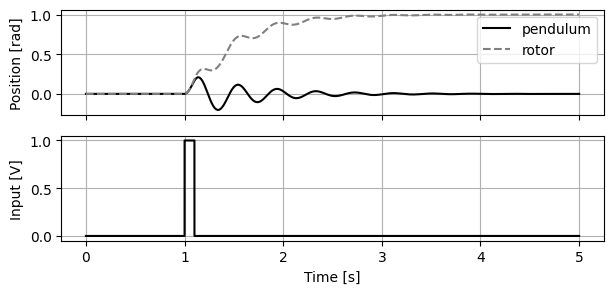

In [2]:
def make_pulse_diagram(plant, name="root"):
    builder = collimator.DiagramBuilder()

    # Construct the input signal as the difference of two
    # unit step functions spaced 0.1 seconds apart
    pulse = make_pulse(amplitude=1.0, start_time=1.0, width=0.1)

    # Connect the adder block to the input port of the plant
    builder.add(pulse, plant)
    builder.connect(pulse.output_ports[0], plant.input_ports[0])

    return builder.build(name=name)


tf = 5.0
plant = library.QubeServoModel()

system = make_pulse_diagram(plant)
context = system.create_context()

# Record time series signals of the input and output ports
recorded_signals = {
    "y": plant.output_ports[0],
    "u": plant.input_ports[0],
}

results = collimator.simulate(
    system,
    context,
    (0.0, tf),
    recorded_signals=recorded_signals,
)


fig, ax = plt.subplots(2, 1, figsize=(7, 3), sharex=True)
ax[0].plot(results.time, results.outputs["y"][:, 1], c='k', label="pendulum")
ax[0].plot(results.time, results.outputs["y"][:, 0], '--', c='grey', label="rotor")
ax[0].set_ylabel("Position [rad]")
ax[0].legend()
ax[0].grid()
ax[1].plot(results.time, results.outputs["u"], c='k', label="pendulum")
ax[1].set_ylabel("Input [V]")
ax[1].set_xlabel("Time [s]")
ax[1].grid()
plt.show()

And again with the hardware

collimator:INFO max_major_steps=998 based on smallest discrete period=0.01
collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=None, max_major_steps=998, ode_solver_method=default, rtol=1e-06, atol=1e-08, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=2, return_context=True), Dopri5Solver(system=Diagram(root, 2 nodes), rtol=1e-06, atol=1e-08, max_step_size=None, min_step_size=None, method='default', enable_autodiff=False)


Initialized Qube
Restoring sigint handler


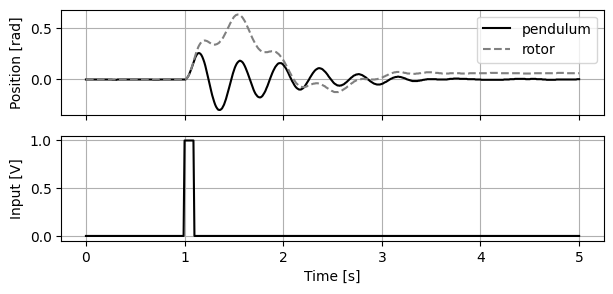

In [4]:
dt = 1 / 100.0  # 100 Hz
plant_hw = library.QuanserHAL(dt=dt, hardware=HARDWARE, version=version, name="QuanserHAL")

tf = 5.0

system = make_pulse_diagram(plant_hw)
context = system.create_context()

# Record time series signals of the input and output ports
recorded_signals = {
    "y": plant_hw.output_ports[0],
    "u": plant_hw.input_ports[0],
}

results = collimator.simulate(
    system,
    context,
    (0.0, tf),
    recorded_signals=recorded_signals,
)
plant_hw.terminate()

fig, ax = plt.subplots(2, 1, figsize=(7, 3), sharex=True)
ax[0].plot(results.time, results.outputs["y"][:, 1], c='k', label="pendulum")
ax[0].plot(results.time, results.outputs["y"][:, 0], '--', c='grey', label="rotor")
ax[0].set_ylabel("Position [rad]")
ax[0].legend()
ax[0].grid()
ax[1].plot(results.time, results.outputs["u"], c='k', label="pendulum")
ax[1].set_ylabel("Input [V]")
ax[1].set_xlabel("Time [s]")
ax[1].grid()
plt.show()


The starting point will be the "plant" model from notebook 01 in nonlinear state space form:

$$
\begin{align*}
\dot{x} &= f(x, u) \\
y &= g(x, u)
\end{align*},
$$

where $x = \begin{bmatrix} \theta & \alpha & \dot{\theta} & \dot{\alpha} \end{bmatrix}^T$ is the state of the system, $u$ are the inputs, and $y$ are the measurements.  In this case, $y = \begin{bmatrix} \theta & \alpha \end{bmatrix}^T$, so there is no "feedthrough" contribution from $u$ in the measurement.

We will first linearize the plant model about the equilibrium point $x_0 = \begin{bmatrix} 0 & 0 & 0 & 0 \end{bmatrix}^T$, $u_0 = 0$, yielding the linear time-invariant (LTI) system

$$
\begin{align*}
\dot{x} &= Ax + Bu \\
y &= Cx,
\end{align*}
$$

where $A = \partial f / \partial x$, $B = \partial f / \partial u$, and $C = \partial g / \partial y$ are the Jacobian matrices of the nonlinear system linearized about the equilibrium point.

In [5]:
# Linearize the system and discretize in time
x_eq = np.array([0.0, 0.0, 0.0, 0.0])
y_eq = x_eq[:2]
u_eq = np.array([0.0])

plant = library.QubeServoModel(full_state_output=False, name="qube")
plant.input_ports[0].fix_value(u_eq)
context = plant.create_context()

base_context = context.with_continuous_state(x_eq)

# Linearize and discretize in time
lin_sys = library.linearize(plant, base_context)

lin_sys

StateSpace(array([[ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [-0.00000000e+00, -1.52005739e+02, -5.06371846e+00,
        -2.50241901e-01],
       [-0.00000000e+00, -2.64307998e+02, -5.00483801e+00,
        -4.35121306e-01]]), array([[ 0.        ],
       [ 0.        ],
       [50.63718457],
       [50.0483801 ]]), array([[1., 0., 0., 0.],
       [0., 1., 0., 0.]]), array([[0.],
       [0.]]))

To quickly eliminate disturbances and "regulate" the system we will add a linear-quadratic regulator (LQR) feedback control law $u = -Kx$.
However, since the full state $x$ is not known to us, we will instead use a Kalman filter to produce an estimate $\hat{x}$ of the state given a series of measurements $y$ in conjunction with the linear dynamics model.

We will use the infinite-horizon form of both the LQR controller and Kalman filter, for which there are implementations in the Collimator block library.

In [6]:
dt = 0.01  # 100 Hz sampling rate

def make_lqg(lin_sys, dt, Q, R, QN, RN):
    dt_sys = lin_sys.sample(dt)

    print(QN)

    kf = library.InfiniteHorizonKalmanFilter(
        dt=dt,
        A=dt_sys.A,
        B=dt_sys.B,
        C=dt_sys.C,
        D=dt_sys.D,
        Q=QN,
        R=RN,
        x_hat_0=np.zeros(n),
        name="kf"
    )
    lqr = library.DiscreteTimeLinearQuadraticRegulator(
        dt=dt,
        A=dt_sys.A,
        B=dt_sys.B,
        Q=Q,
        R=R,
        name="lqr"
    )
    print(lqr.K)

    # Construct the closed-loop block diagram
    builder = collimator.DiagramBuilder()
    builder.add(kf, lqr)

    # One input port: y
    builder.export_input(kf.input_ports[1], name="y")

    builder.connect(kf.output_ports[0], lqr.input_ports[0])
    builder.connect(lqr.output_ports[0], kf.input_ports[0])

    # Two output ports: u and x_hat
    builder.export_output(lqr.output_ports[0], name="u")
    builder.export_output(kf.output_ports[0], name="x_hat")

    return builder.build(name="LQG")


n = lin_sys.A.shape[0]  # State dimension
m = lin_sys.B.shape[1]  # Input dimension
p = lin_sys.C.shape[0]  # Output dimension

# Covariance matrices for LQR
Q = np.eye(n)
R = 1e-2 * np.eye(m)

# Covariance matrices for Kalman filter
noise_scale = 1e2
QN = noise_scale * np.eye(m)
RN = np.eye(p)

controller = make_lqg(lin_sys, dt, Q, R, QN, RN)
controller.pprint()

[[100.]]
[[1.36679276 9.98630993 1.40627493 0.55464866]]
|-- LQG
    |-- kf(id=17)
    |-- lqr(id=18)


In [6]:
def make_lqg_diagram(plant, controller, pulse_amplitude=1.0, name="root"):

    # Add initial impulse
    pulse = make_pulse(amplitude=pulse_amplitude, start_time=2.0, width=0.1)
    adder = library.Adder(2, name="adder")

    builder = collimator.DiagramBuilder()
    builder.add(plant, controller, pulse, adder)

    # Connect the plant to the LQG controller
    builder.connect(plant.output_ports[0], controller.input_ports[0])

    builder.connect(controller.output_ports[0], adder.input_ports[0])
    builder.connect(pulse.output_ports[0], adder.input_ports[1])
    builder.connect(adder.output_ports[0], plant.input_ports[0])

    return builder.build(name=name)

collimator:INFO max_major_steps=998 based on smallest discrete period=0.01
collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=None, max_major_steps=998, ode_solver_method=default, rtol=1e-06, atol=1e-08, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=2, return_context=True), Dopri5Solver(system=Diagram(root, 4 nodes), rtol=1e-06, atol=1e-08, max_step_size=None, min_step_size=None, method='default', enable_autodiff=False)


|-- root
    |-- Qube_19_(id=19)
    |-- LQG
        |-- kf(id=16)
        |-- lqr(id=17)
    |-- Pulse
        |-- step1(id=20)
        |-- step2(id=21)
        |-- adder(id=22)
    |-- adder(id=24)


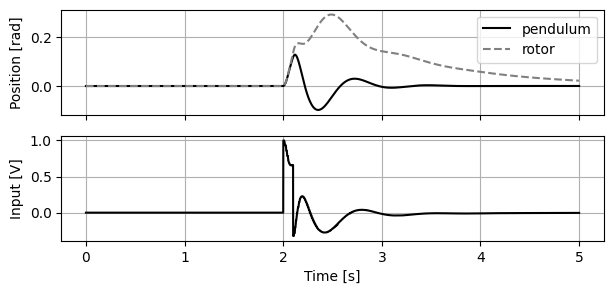

In [7]:
tf = 5.0
plant = library.QubeServoModel()

system = make_lqg_diagram(plant, controller)
system.pprint()
context = system.create_context()

# Record time series signals of the input and output ports
recorded_signals = {
    "y": plant.output_ports[0],
    "u": plant.input_ports[0],
}

results = collimator.simulate(
    system,
    context,
    (0.0, tf),
    recorded_signals=recorded_signals,
)


fig, ax = plt.subplots(2, 1, figsize=(7, 3), sharex=True)
ax[0].plot(results.time, results.outputs["y"][:, 1], c='k', label="pendulum")
ax[0].plot(results.time, results.outputs["y"][:, 0], '--', c='grey', label="rotor")
ax[0].set_ylabel("Position [rad]")
ax[0].legend()
ax[0].grid()
ax[1].plot(results.time, results.outputs["u"], c='k', label="pendulum")
ax[1].set_ylabel("Input [V]")
ax[1].set_xlabel("Time [s]")
ax[1].grid()
plt.show()

The disturbance is damped much more quickly than in the uncontrolled case.  Finally, we can run the same controller on the hardware by changing the "plant" from the analytic model to the HAL block.  If you have the hardware, try extending the run time (to 20 or 30 seconds) and bumping the pendulum; compare the response of the system to the natural oscillations.

collimator:INFO max_major_steps=998 based on smallest discrete period=0.01
collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=None, max_major_steps=998, ode_solver_method=default, rtol=1e-06, atol=1e-08, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=2, return_context=True), Dopri5Solver(system=Diagram(root, 4 nodes), rtol=1e-06, atol=1e-08, max_step_size=None, min_step_size=None, method='default', enable_autodiff=False)


Initialized Qube
|-- root
    |-- QuanserHAL(id=30)
    |-- LQG
        |-- kf(id=27)
        |-- lqr(id=28)
    |-- Pulse
        |-- step1(id=31)
        |-- step2(id=32)
        |-- adder(id=33)
    |-- adder(id=35)
Restoring sigint handler


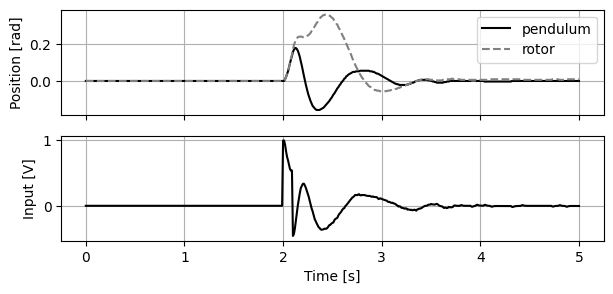

In [8]:
controller = make_lqg(lin_sys, dt, Q, R, QN, RN)
plant_hw = library.QuanserHAL(dt=dt, hardware=HARDWARE, version=version, name="QuanserHAL")

system = make_lqg_diagram(plant_hw, controller)
system.pprint()
context = system.create_context()

# Record time series signals of the input and output ports
recorded_signals = {
    "y": plant_hw.output_ports[0],
    "u": plant_hw.input_ports[0],
}

tf = 5.0
results = collimator.simulate(
    system,
    context,
    (0.0, tf),
    recorded_signals=recorded_signals,
)
plant_hw.terminate()

fig, ax = plt.subplots(2, 1, figsize=(7, 3), sharex=True)
ax[0].plot(results.time, results.outputs["y"][:, 1], c='k', label="pendulum")
ax[0].plot(results.time, results.outputs["y"][:, 0], '--', c='grey', label="rotor")
ax[0].set_ylabel("Position [rad]")
ax[0].legend()
ax[0].grid()
ax[1].plot(results.time, results.outputs["u"], c='k', label="pendulum")
ax[1].set_ylabel("Input [V]")
ax[1].set_xlabel("Time [s]")
ax[1].grid()
plt.show()